In [0]:
import os
import cv2
import keras
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

Shapes generation utilities

In [0]:
def drawCirle(image, circle, color):
  (x, y), r, _, _ = circle
  cv2.circle(image, (x, y), r, color, -1)
  
def xs(index, step, alpha, r):
  return r*math.cos(alpha + step*index)

def ys(index, step, alpha, r):
  return r*math.sin(alpha + step*index)
  
def drawPolygon(image, shape, sides, color):
    (x, y), r, shape_type, alpha = shape
    step = 2.0*math.pi/sides
    points = np.array([(x + xs(i, step, alpha, r), y + ys(i, step, alpha, r)) for i in range(sides)], np.int32)
    cv2.fillConvexPoly(image, points, color)

def checkIntersect(c1, c2):
    (x1, y1), r1, _, _ = c1
    (x2, y2), r2, _, _ = c2
    return (x1-x2)**2 + (y1-y2)**2 < (1.2*(r1+r2))**2

def checkIntersections(shapes, circle):
    for s in shapes:
        if checkIntersect(s, circle):
            return True
    return False
  
DrawMap = [
    lambda image, shape, color: drawCirle  (image, shape, color)   ,
    lambda image, shape, color: drawPolygon(image, shape, 3, color),
    lambda image, shape, color: drawPolygon(image, shape, 4, color),
    lambda image, shape, color: drawPolygon(image, shape, 5, color)
]

VizMap = [
    (255, 0  , 0  ), # circle red
    (0  , 255, 0  ), # triangle green
    (0  , 0  , 255), # quad blue
    (255, 255, 0  )  # pentagon yellow
]

INPUT_CHANNELS    = 1
NUMBER_OF_CLASSES = 5
RADIUS = 48
WIDTH  = 512
HEIGHT = 512
MAX_SHAPES = 40

def generateShapes():
  shapes = []
  for i in range(MAX_SHAPES):
    shape_type = random.randrange(4)
    r = RADIUS
    x = random.randint(r, WIDTH  - r)
    y = random.randint(r, HEIGHT - r)
    alpha = 2*math.pi*random.random()
    shape = (x,y), r, shape_type, alpha
    if checkIntersections(shapes, shape) == False:
      shapes.append(shape)
      
  return shapes
  
def generateImage(shapes):
  image  = np.zeros((HEIGHT,WIDTH, INPUT_CHANNELS), np.uint8)
  labels = np.zeros((HEIGHT,WIDTH, NUMBER_OF_CLASSES), np.uint8)
  viz    = np.zeros((HEIGHT,WIDTH, 3), np.uint8)
  
  masks = []
  for i in range(5):
    masks.append(np.zeros((HEIGHT, WIDTH, 1), dtype=np.uint8))
  
  for shape in shapes:
    _, _, shape_type, alpha = shape
    
    drawFunc = DrawMap [shape_type]
    vizColor = VizMap  [shape_type]
    
    mask = masks[shape_type + 1]
    
    drawFunc(image , shape, (255, 255, 255))
    drawFunc(mask  , shape, (255, 255, 255))
    drawFunc(viz   , shape, vizColor)
    
  mask_or = np.zeros((HEIGHT, WIDTH, 1), dtype=np.uint8)
  for i in range(1, 5):
    mask_or = cv2.bitwise_or(masks[i], mask_or)
    labels[:, :, i] = np.squeeze(masks[i])
       
  masks[0] = cv2.bitwise_not(mask_or)
  labels[:, :, 0] = np.squeeze(masks[0])
    
  return image, labels, viz



Test shapes generation

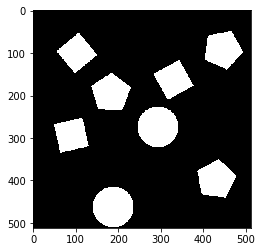

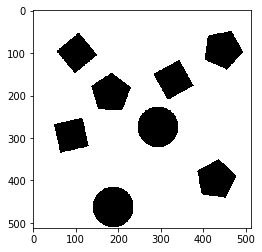

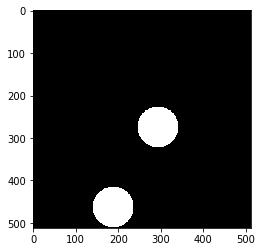

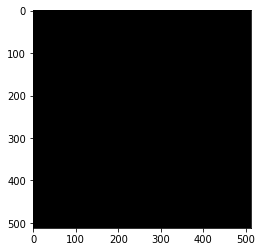

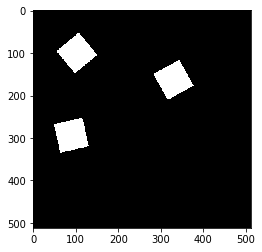

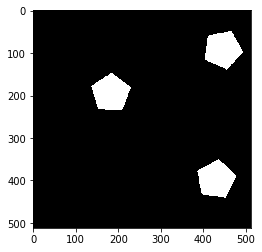

In [13]:
shapes = generateShapes()

image, labels, viz = generateImage(shapes)

image_     = image [:, :, 0]
background = labels[:, :, 0]
circle     = labels[:, :, 1]
triangle   = labels[:, :, 2]
quad       = labels[:, :, 3]
pentagon   = labels[:, :, 4]

plt.imshow(image_, cmap='gray')
plt.show()

plt.imshow(background, cmap='gray')
plt.show()

plt.imshow(circle, cmap='gray')
plt.show()

plt.imshow(triangle, cmap='gray')
plt.show()

plt.imshow(quad, cmap='gray')
plt.show()

plt.imshow(pentagon, cmap='gray')
plt.show()

Generate training/validation dataset

In [14]:
images=[]
num_tot = 0
num_0 = 0
num_1 = 0
num_2 = 0
num_3 = 0
num_4 = 0

number_of_shapes = 10000

import progressbar
bar = progressbar.ProgressBar(maxval=number_of_shapes, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

bar.start()
for i in range(number_of_shapes):
  shapes = generateShapes()
  image, labels, viz = generateImage(shapes)
  
  num_tot = WIDTH * HEIGHT
  num_0   += (labels[:, :, 0] == 255).sum() / num_tot
  num_1   += (labels[:, :, 1] == 255).sum() / num_tot
  num_2   += (labels[:, :, 2] == 255).sum() / num_tot
  num_3   += (labels[:, :, 3] == 255).sum() / num_tot
  num_4   += (labels[:, :, 4] == 255).sum() / num_tot
  
  bar.update(i+1)
  images.append(shapes)
  
bar.finish()

xTrain, xTest = train_test_split(np.arange(0, len(images)), random_state=0, test_size=0.1)

print('Generated {} images'.format(len(images)))
print('Generated {} training images'.format(len(xTrain)))
print('Generated {} test     images'.format(len(xTest)))

[========================================================================] 100%


Generated 10000 images
Generated 9000 training images
Generated 1000 test     images


Data Generator

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, images, batch_size=16, dim=(WIDTH,HEIGHT), n_channels=1,
                 n_classes=5, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.images = images
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.uint8)
        y = np.empty((self.batch_size, *self.dim, NUMBER_OF_CLASSES), dtype=np.uint8)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
          
            shapes = self.images[ID]
            
            image, labels, _ = generateImage(shapes)
          
            # Store sample
            X[i,] = image

            # Store class
            y[i, ] = labels

        X = X.astype(np.float32)
        X /= 255.0
        
        y = y.astype(np.float32)
        y /= 255.0
        
        y = y.reshape(self.batch_size, HEIGHT * WIDTH, NUMBER_OF_CLASSES)
        
        return X, y
      
train_generator = DataGenerator(xTrain, images)
val_generator   = DataGenerator(xTest , images)

Test Generator

(16, 512, 512, 1)
(16, 262144, 5)
(16, 512, 512, 5)


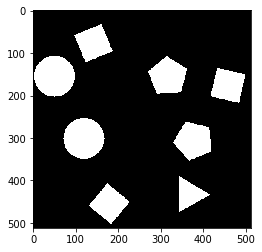

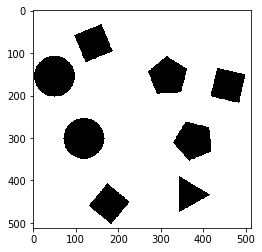

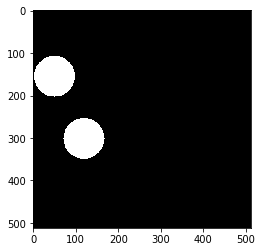

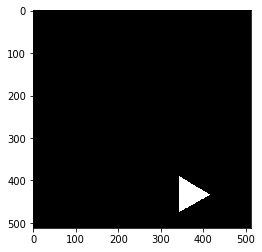

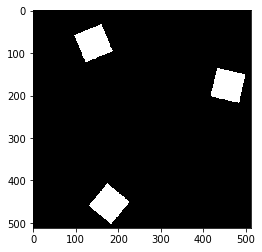

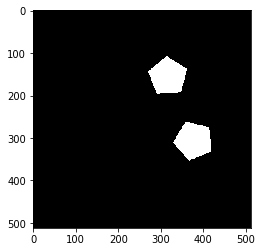

In [18]:
X, y = train_generator.__getitem__(0)

print(X.shape)
print(y.shape)

y = y.reshape(y.shape[0], WIDTH, HEIGHT, NUMBER_OF_CLASSES)

print(y.shape)

image      = X[0, :, :, 0]
background = y[0, :, :, 0]
circle     = y[0, :, :, 1]
triangle   = y[0, :, :, 2]
quad       = y[0, :, :, 3]
pentagon   = y[0, :, :, 4]

plt.imshow(image, cmap='gray')
plt.show()

plt.imshow(background, cmap='gray')
plt.show()

plt.imshow(circle, cmap='gray')
plt.show()

plt.imshow(triangle, cmap='gray')
plt.show()

plt.imshow(quad, cmap='gray')
plt.show()

plt.imshow(pentagon, cmap='gray')
plt.show()

Model specification

In [19]:
def dice(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def unet(inputs, n_classes, base=4):

    b = base

    c1 = keras.layers.Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = keras.layers.Dropout(0.1) (c1)
    c1 = keras.layers.Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = keras.layers.MaxPooling2D((2, 2)) (c1)

    c2 = keras.layers.Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = keras.layers.Dropout(0.1) (c2)
    c2 = keras.layers.Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = keras.layers.MaxPooling2D((2, 2)) (c2)

    c3 = keras.layers.Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = keras.layers.Dropout(0.2) (c3)
    c3 = keras.layers.Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = keras.layers.MaxPooling2D((2, 2)) (c3)

    c4 = keras.layers.Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = keras.layers.Dropout(0.2) (c4)
    c4 = keras.layers.Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = keras.layers.MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = keras.layers.Conv2D(2**(b+4), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = keras.layers.Dropout(0.3) (c5)
    c5 = keras.layers.Conv2D(2**(b+4), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = keras.layers.Conv2DTranspose(2**(b+3), (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = keras.layers.concatenate([u6, c4])
    c6 = keras.layers.Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = keras.layers.Dropout(0.2) (c6)
    c6 = keras.layers.Conv2D(2**(b+3), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = keras.layers.Conv2DTranspose(2**(b+2), (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = keras.layers.concatenate([u7, c3])
    c7 = keras.layers.Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = keras.layers.Dropout(0.2) (c7)
    c7 = keras.layers.Conv2D(2**(b+2), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = keras.layers.Conv2DTranspose(2**(b+1), (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = keras.layers.concatenate([u8, c2])
    c8 = keras.layers.Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = keras.layers.Dropout(0.1) (c8)
    c8 = keras.layers.Conv2D(2**(b+1), (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = keras.layers.Conv2DTranspose(2**b, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = keras.layers.concatenate([u9, c1], axis=3)
    c9 = keras.layers.Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = keras.layers.Dropout(0.1) (c9)
    c9 = keras.layers.Conv2D(2**b, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    o = keras.layers.Conv2D(n_classes, (1, 1), activation='linear') (c9)

    return o
  
inputs = keras.layers.Input((HEIGHT, WIDTH, INPUT_CHANNELS))

base = unet(inputs, NUMBER_OF_CLASSES)

base = keras.layers.Reshape((HEIGHT * WIDTH, NUMBER_OF_CLASSES))(base)
activation = keras.layers.Activation('softmax')(base)
    
model = keras.Model(inputs=inputs, outputs=activation)
model.compile(optimizer=keras.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=[dice])#sample_weight_mode='temporal', metrics=[dice])
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512, 512, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 16) 2320        drop

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')
print(os.listdir('/content/gdrive/My Drive'))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
['Emb3D_Business_Plan.gdoc', 'PreventivoLeonardo.gdoc', 'PreventivoBelmonte.gdoc', 'lcd7seg-master.zip', 'Coursera - Bayesian Methods for Machine Learning', 'sasso.7z', 'Foglio di lavoro senza nome.gsheet', 'Colab Notebooks', 'FS -TNL CONTRATTO DI APPALTO PER RAYTRACER 1.pdf', 'NetFarm.gsheet', 'Copia di QuipuFacSimileFattura.gsheet', 'model.h5']


Model Training

In [22]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/gdrive/My Drive/model.h5', 
    monitor='val_dice', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='max'
)

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_dice', mode='max', verbose=1, patience=10)

#from keras.models import load_model

#model = load_model('/content/gdrive/My Drive/model.h5', custom_objects={'dice': dice})

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, earlyStopping],
    use_multiprocessing=True,
    workers=1,
    epochs=20
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
562/562 [==============================] - 828s 1s/step - loss: 0.1847 - dice: 0.9031 - val_loss: 0.0051 - val_dice: 0.9962

Epoch 00001: val_dice improved from -inf to 0.99623, saving model to /content/gdrive/My Drive/model.h5
Epoch 2/20
562/562 [==============================] - 798s 1s/step - loss: 0.0013 - dice: 0.9991 - val_loss: 3.5275e-04 - val_dice: 0.9998

Epoch 00002: val_dice improved from 0.99623 to 0.99977, saving model to /content/gdrive/My Drive/model.h5
Epoch 3/20
562/562 [==============================] - 797s 1s/step - loss: 2.3465e-04 - dice: 0.9998 - val_loss: 1.5630e-04 - val_dice: 0.9999

Epoch 00003: val_dice improved from 0.99977 to 0.99990, saving model to /content/gdrive/My Drive/model.h5
Epoch 4/20
562/562 [==============================] - 803s 1s/step - loss: 1.1052e-04 - dice: 0.9999 - val_loss: 1.7110e-04 - val_dice: 0.9999

Epoch 00004: val_dice impro

Test Predictions

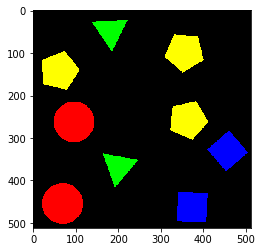

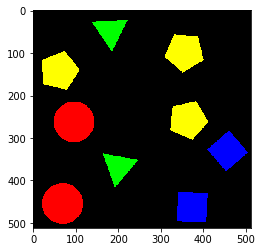

0.99998521807629


In [27]:
def dicenp(y_true, y_pred, smooth=1.):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

test_shapes = generateShapes()
image, labels, viz  = generateImage(test_shapes)

plt.imshow(viz)
plt.show()

z = np.empty((1, WIDTH, HEIGHT, 1), dtype=np.uint8)
z[0, :, :, :] = image

z = z.astype(np.float32)
z /= 255.0

prediction = model.predict(z)

labels = labels.astype(np.float32)
labels /= 255.0

prediction = prediction.reshape(1, WIDTH, HEIGHT, NUMBER_OF_CLASSES)

cmax = np.argmax(prediction, axis=3)
cmax = cmax[0, :, :]

viz_pred = np.zeros((HEIGHT, WIDTH, 3), np.uint8)

for ix,iy in np.ndindex(cmax.shape):
    shape_type = cmax[ix,iy]
    if shape_type == 0:
      viz_pred[ix,iy] = [0, 0, 0]
    else:
      viz_pred[ix,iy] = VizMap[shape_type - 1]
     
    
plt.imshow(viz_pred)
plt.show()

# Print dice coefficent
dice_coeff = dicenp(labels, prediction)
print(dice_coeff)